In [1]:
from active_learning import ActiveLearner

In [2]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
sns.set_theme(style='darkgrid')
warnings.filterwarnings("ignore")

#### Create dummy classification data using sklearn

In [4]:
X, y = make_classification(n_samples = 10000,
                           n_features = 10, n_informative = 7, n_redundant = 0,
                           flip_y = 0.025, n_clusters_per_class = 5, 
                           weights = np.array([0.9, 0.1]), class_sep = 3,
                           random_state = 30
                          )

In [5]:
print(f"Feature matrix dimensions: {X.shape} \nNumber of positive (friends in ReGroup paper) instances = {y.sum()} ({y.sum()*100 / len(y)}%) of out total {y.shape[0]}")

Feature matrix dimensions: (10000, 10) 
Number of positive (friends in ReGroup paper) instances = 1095 (10.95%) of out total 10000


<AxesSubplot:>

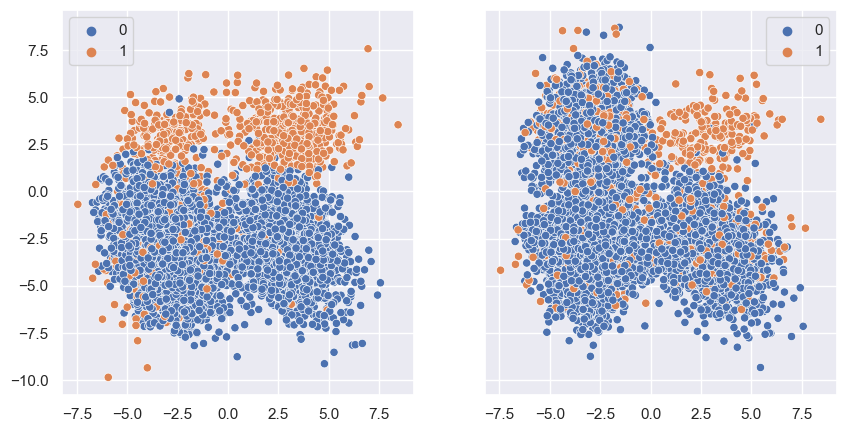

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y, ax = ax1)
sns.scatterplot(x = X[:, 0], y = X[:, 2], hue = y, ax = ax2)

#### Fit offline naive bayes model on generated data and report f1 and accuracy scores (k-fold = 10)

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate

In [8]:
clf = GaussianNB()
cv = StratifiedKFold(n_splits=10)
metrics = ['f1', 'accuracy']
scores = cross_validate(clf, X, y, scoring=metrics, cv = cv)

In [9]:
for metric in metrics:
    print(f"{metric}: {scores['test_' + metric].mean():.4f} \u00B1 {scores['test_' + metric].std():.4f}")

f1: 0.6427 ± 0.0246
accuracy: 0.9336 ± 0.0041


#### We will sample few initial instaces to implement different active learning strategies and keep them in `X_initial_selection` and `y_initial_selection`

In [10]:
np.random.seed(19)
random_10_indices = np.random.choice(range(len(y)), 10)
X_initial_selection, y_initial_selection = X[random_10_indices, :], y[random_10_indices]

In [11]:
print(f"Number of positive cases in intial random 10 cases: {y_initial_selection.sum()}")

Number of positive cases in intial random 10 cases: 4


In [12]:
mask = np.ones(X.shape[0], dtype=bool)
mask[random_10_indices] = False
X_sample, y_sample = X[mask, :], y[mask]

In [13]:
X_sample.shape, y_sample.shape

((9990, 10), (9990,))

In [14]:
y_sample.sum()

1091

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, stratify=y_sample, test_size=0.20, random_state = 30)

print(f"Interactive Training Data Shape: {X_train.shape} , positive cases: {y_train.sum()}\nTest (Benchmark) Data Shape: {X_test.shape} , positive cases: {y_test.sum()}")

Interactive Training Data Shape: (7992, 10) , positive cases: 873
Test (Benchmark) Data Shape: (1998, 10) , positive cases: 218


---

### Query Strategy 1: ReGroup

$$x^* := highest\: probability\: case\: with\: positive\: true\: class\: as\: picked\: up\: by\: user\: (oracle)\: interactively\:$$

Caveat: Unlearnable Groups - instances' probability are discounted based on how many times they are skipped (not picked up by human).

$$P(g \mid x)=P(g \mid x) * v^n$$

where,
$n =$ number of times instance is skipped (or not picked) and

$v =$ unlearnable_group_discount_factor

In [16]:
regroup_perf = {}
regroup = ActiveLearner(X_initial_selection, y_initial_selection)
regroup_perf['f1'], regroup_perf['acc'] = regroup.initiate_interactive_training(X_train, y_train,
                                                                                strategy = 'regroup',
                                                                                unlearnable_group_discount_factor = 0.9, 
                                                                                X_benchmark=X_test, y_benchmark=y_test)

Using GaussianNB() by default


<AxesSubplot:>

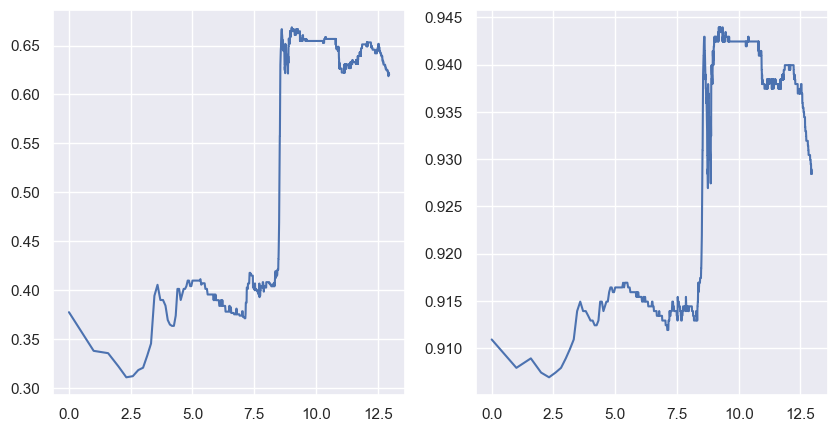

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10,5))
# sns.lineplot(y = acc_hist, x = list(range(0, len(acc_hist))), ax = ax1)
# sns.lineplot(y = f1_hist, x = list(range(0, len(f1_hist))), ax = ax2)

sns.lineplot(y = regroup_perf['f1'], x = np.log2(list(range(0, len(regroup_perf['f1'])))), ax = ax1)
sns.lineplot(y = regroup_perf['acc'], x = np.log2(list(range(0, len(regroup_perf['acc'])))), ax = ax2)

---

### Query Strategy 2: Uncertainity Based Query Sampling (UBQS)

$$x^* := instance\: which \: the\: algorithm\: is\: least\: confident\: about\: OR\: is\: most\: likely\: to\: mislabel$$

In binary classification tasks, UBQS (**where uncertainty is defined by entropy**) simply queries the instance whose posterior probability of being positive is nearest 0.5

In [18]:
ubqs_perf = {}
ubqs = ActiveLearner(X_initial_selection, y_initial_selection)
ubqs_perf['f1'], ubqs_perf['acc'] = ubqs.initiate_interactive_training(X_train, y_train, strategy = 'UBQS',
                                                          relative_density_importance = 1, 
                                                          X_benchmark=X_test, y_benchmark=y_test)

Using GaussianNB() by default


<AxesSubplot:>

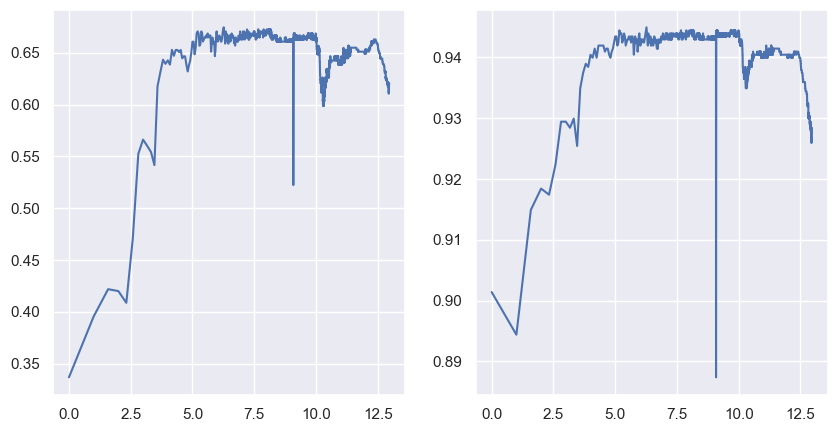

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10,5))
# sns.lineplot(y = acc_hist, x = list(range(0, len(acc_hist))), ax = ax1)
# sns.lineplot(y = f1_hist, x = list(range(0, len(f1_hist))), ax = ax2)

sns.lineplot(y = ubqs_perf['f1'], x = np.log2(list(range(0, len(ubqs_perf['f1'])))), ax = ax1)
sns.lineplot(y = ubqs_perf['acc'], x = np.log2(list(range(0, len(ubqs_perf['acc'])))), ax = ax2)

---

### Query Strategy 3: Information Density

- In UBQS, we pick the query instance model is MOST uncertain about (where uncertainty is defined by entropy).

- In practice, this startegy is prone to querying outliers.

- The main idea is that informative instances should not only be those which are uncertain, but also those which are “representative” of the underlying distribution (i.e., inhabit dense regions of the input space).


$$
x_{I D}^*=\underset{x}{\operatorname{argmax}} \phi_A(x) \times\left(\frac{1}{U} \sum_{u=1}^U \operatorname{sim}\left(x, x^{(u)}\right)\right)^\beta .
$$


where 
- $\phi_A(x)$ represents the informativeness of x according to some “base” query strategy A - which is UBQS in our implementation, 
- Term on the right is average similarity average similarity to all other (other than x) instances. 
- For our implementation, we use 
- Parameter $\beta$ is controls the relative importance of the density term

In [30]:
ubqs_id_perf = {}
ubqs_id = ActiveLearner(X_initial_selection, y_initial_selection)
ubqs_id_perf['f1'], ubqs_id_perf['acc'] = ubqs_id.initiate_interactive_training(X_train, y_train, strategy = 'information_density',
                                                                                X_benchmark=X_test, y_benchmark=y_test,
                                                                                relative_density_importance = 3)

Using GaussianNB() by default
{'relative_density_importance': 3}


<AxesSubplot:>

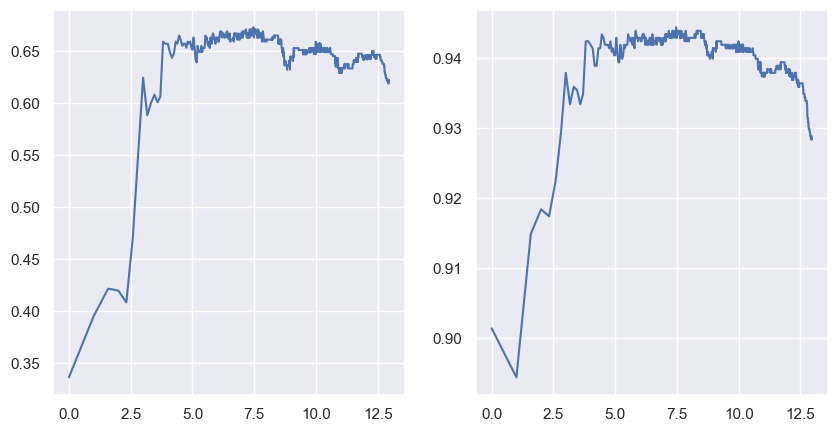

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10,5))
# sns.lineplot(y = ubqs_id_perf['acc'], x = list(range(0, len(ubqs_id_perf['acc']))), ax = ax1)
# sns.lineplot(y = ubqs_id_perf['f1'], x = list(range(0, len(ubqs_id_perf['f1']))), ax = ax2)

sns.lineplot(y = ubqs_id_perf['f1'], x = np.log2(list(range(0, len(ubqs_id_perf['f1'])))), ax = ax1)
sns.lineplot(y = ubqs_id_perf['acc'], x = np.log2(list(range(0, len(ubqs_id_perf['acc'])))), ax = ax2)

In [22]:
passive_perf = {}
passive_learner = ActiveLearner(X_initial_selection, y_initial_selection)
passive_perf['f1'], passive_perf['acc'] = passive_learner.initiate_interactive_training(X_train, y_train, strategy = 'passive_learning',
                                                                             X_benchmark=X_test, y_benchmark=y_test)

Using GaussianNB() by default
This strategy queries instaces at random and is used to benchmark other strategies


<AxesSubplot:>

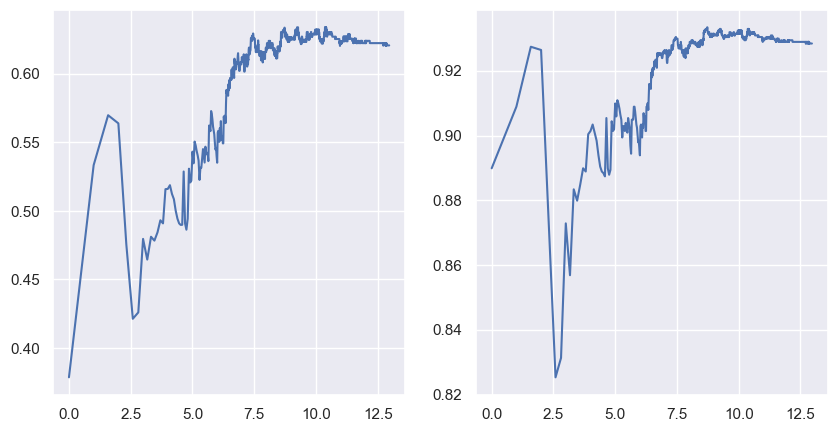

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10,5))
# sns.lineplot(y = passive_perf['acc'], x = list(range(0, len(passive_perf['acc']))), ax = ax1)
# sns.lineplot(y = passive_perf['f1'], x = list(range(0, len(passive_perf['f1']))), ax = ax2)

sns.lineplot(y = passive_perf['f1'], x = np.log2(list(range(0, len(passive_perf['f1'])))), ax = ax1)
sns.lineplot(y = passive_perf['acc'], x = np.log2(list(range(0, len(passive_perf['acc'])))), ax = ax2)

<AxesSubplot:xlabel='log2(number of training examples)', ylabel='accuracy'>

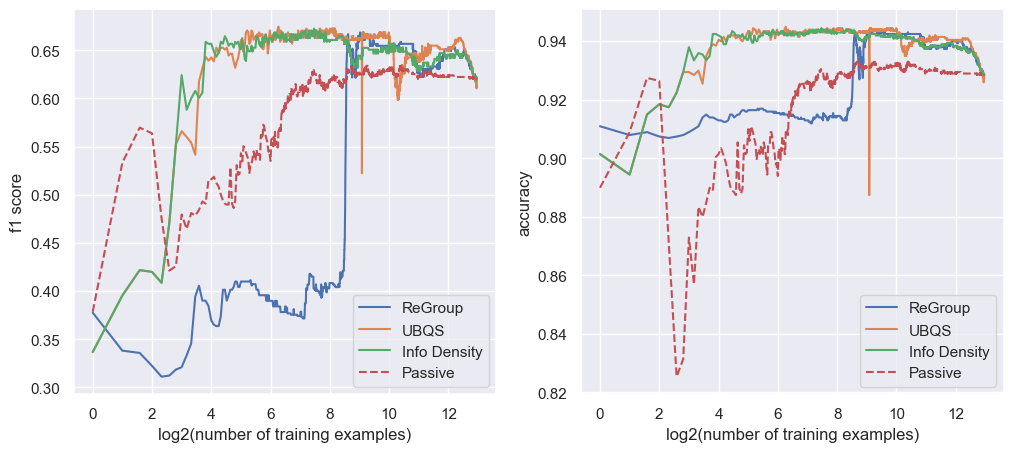

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12,5))
# sns.lineplot(y = passive_perf['acc'], x = list(range(0, len(passive_perf['acc']))), ax = ax1)
# sns.lineplot(y = passive_perf['f1'], x = list(range(0, len(passive_perf['f1']))), ax = ax2)

ax1.set(ylabel='f1 score', xlabel='log2(number of training examples)')
ax2.set(ylabel='accuracy', xlabel='log2(number of training examples)')

sns.lineplot(y = regroup_perf['f1'], x = np.log2(list(range(0, len(regroup_perf['f1'])))), ax = ax1, label = 'ReGroup')
sns.lineplot(y = ubqs_perf['f1'], x = np.log2(list(range(0, len(ubqs_perf['f1'])))), ax = ax1, label = 'UBQS')
sns.lineplot(y = ubqs_id_perf['f1'], x = np.log2(list(range(0, len(ubqs_id_perf['f1'])))), ax = ax1, label = 'Info Density')
sns.lineplot(y = passive_perf['f1'], x = np.log2(list(range(0, len(passive_perf['f1'])))), ax = ax1, linestyle = '--', label = 'Passive')
ax1.legend(loc = 'lower right')

sns.lineplot(y = regroup_perf['acc'], x = np.log2(list(range(0, len(regroup_perf['f1'])))), ax = ax2, label = 'ReGroup')
sns.lineplot(y = ubqs_perf['acc'], x = np.log2(list(range(0, len(ubqs_perf['f1'])))), ax = ax2, label = 'UBQS')
sns.lineplot(y = ubqs_id_perf['acc'], x = np.log2(list(range(0, len(ubqs_id_perf['f1'])))), ax = ax2, label = 'Info Density')
sns.lineplot(y = passive_perf['acc'], x = np.log2(list(range(0, len(passive_perf['acc'])))), ax = ax2, linestyle = '--', label = 'Passive')

In [35]:
fig.savefig('performance_comparison.png')